In [17]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# may have to pip install it: 
# pip install pycountry
import pycountry
import os
data_folder = 'data'

In [18]:
def get_country_name(country_code, alpha=True):
    if alpha:
        return pycountry.countries.get(alpha_3=country_code).name
    else:
        return pycountry.countries.get(numeric=country_code).name

## Data preparation

In [19]:
file_path = os.sep.join([data_folder, 'Abel', 'migflows_allcountries_gender_separated_1990_2015.csv'])
df = pd.read_csv(file_path)
print(f'Number of rows in original dataset: {df.shape[0]}.')

# select only time intervals of 5 years from 1990 to 2015 
df = df[(df.interval == 5) & (df.year0 >= 1990)]
print(f'Number of rows after filtering time interval: {df.shape[0]}.')

# remove irrelevant and redundant columns
df.drop(columns=['stock', 'demo', 'interval', 'orig_code', 'dest_code'], inplace=True)

# get all countries in dataset
countries = set(df.orig.unique()).union(df.dest.unique())
print(f'There are {len(countries)} countries in MigrFlowSex dataset.')

iso_countries = {country.alpha_3 for country in pycountry.countries}
not_iso_countries = countries - iso_countries
print(f'There are {len(not_iso_countries)} not-ISO countries.')

# remove not-ISO countries
print(f"Let's remove them.")
df = df[~(df['orig'].isin(not_iso_countries) | df['dest'].isin(not_iso_countries))]
print(f'Number of rows after removing non-ISO countries {df.shape[0]}.')

countries_clean = set(df.orig.unique()).union(df.dest.unique())
assert len(countries_clean) == (len(countries) - len(not_iso_countries))
print(f'There are {len(countries_clean)} countries after removal.')

df_out = pd.pivot_table(df, values='flow', index=['year0', 'sex', 'orig'], columns='dest')
print(f'Number of rows in out-flow dataset: {df_out.shape[0]}.')
# compute total out-flow `sum_out` for each country
df_out['sum_out'] = df_out.sum(axis=1)
# compute maximum out-flow `max_out` for each country
df_out['max_out'] = df_out.max(axis=1)
# sort according to cumulative outflow
df_out = df_out.sort_values('sum_out', ascending=False).sort_index(level=[0, 1], sort_remaining=False)

df_in = pd.pivot_table(df, values='flow', index=['year0', 'sex', 'dest'], columns='orig')
print(f'Number of rows in in-flow dataset: {df_in.shape[0]}.')
# compute total in-flow `sum_in` for each country
df_in['sum_in'] = df_in.sum(axis=1)
# compute maximum in-flow `max_in` for each country
df_in['max_in'] = df_in.max(axis=1)
# sort according to cumulative inflow
df_in = df_in.sort_values('sum_in', ascending=False).sort_index(level=[0, 1], sort_remaining=False)

# select only sum and max flows
df_out_thin = df_out[['sum_out', 'max_out']]
df_in_thin = df_in[['sum_in', 'max_in']]

# join flows in and out in single dataframe `df_thin`
df_thin = df_in_thin.copy()
df_thin.index.rename(['year0', 'sex', 'orig'], inplace=True)
df_thin = df_thin.join(df_out_thin, how='inner')

# add population of each country for each time interval
file_path = os.sep.join([data_folder, 'Abel', 'pop.csv'])
df_pop = pd.read_csv(file_path)
df_pop.drop(columns='name', inplace=True)
df_pop.rename(columns={'year': 'year0', 'alpha3': 'orig'}, inplace=True)
df_pop.set_index(['year0', 'orig'], inplace=True)

# join population data with flows
df_thin = df_thin.merge(df_pop, how='inner', left_on=['year0', 'orig'], right_index=True)
# df_thin = df_thin.merge(df_pop, how='left', left_on=['year0', 'orig'], right_index=True)

df_thin.isnull().sum()

Number of rows in original dataset: 10321454.
Number of rows after filtering time interval: 4901986.
There are 204 countries in MigrFlowSex dataset.
There are 4 not-ISO countries.
Let's remove them.
Number of rows after removing non-ISO countries 4755853.
There are 200 countries after removal.
Number of rows in out-flow dataset: 2943.
Number of rows in in-flow dataset: 2943.


sum_in     0
max_in     0
sum_out    0
max_out    0
pop        0
dtype: int64

## Data analysis

### Let's first look at the countries with the highest number of migrant in-flows and out-flows respectively
We constrained the analysis to the most recent time interval: 2010-2015, and for men and women aggregated together.

In [20]:
def get_df_with_k_max_coutries(df_thin, colname, year0, gender, k, normalize=False):
    df_thin = df_thin.copy()
    if normalize:
        df_thin[colname] = df_thin[colname] / df_thin['pop']
        df_thin.drop(columns=[col for col in df_thin.columns if col not in [colname, 'pop']], inplace=True)
    return df_thin.sort_values(colname, ascending=False) \
        .sort_index(level=['year0', 'sex'], sort_remaining=False) \
        .loc[(year0, gender, slice(None)), :] \
        .head(k)

In [21]:
def plot_country_bars(df, metric, direction, normalize=False):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    colname = f'{metric}_{direction}'
    country_codes = df.index.get_level_values('orig').values
    year0 = df.index.get_level_values('year0')[0]
    time_interval = f'{year0}-{year0 + 5}'
    ax.bar(country_codes, df[colname].values)
    if ~normalize:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_title(f'Countries with largest {"normalized" if normalize else ""} {direction}-flow of migrants in {time_interval}', pad=20)
    ax.set_xlabel('Country')
    ax.set_ylabel(f'{"Normalized number" if normalize else "Number"} of migrants flowing {direction}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # add text box with country names:
    country_names_str = '\n'.join([f'{country_code}: {get_country_name(country_code)}' for country_code in country_codes])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(1, 1, country_names_str, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right', bbox=props)
    
    return fig, ax

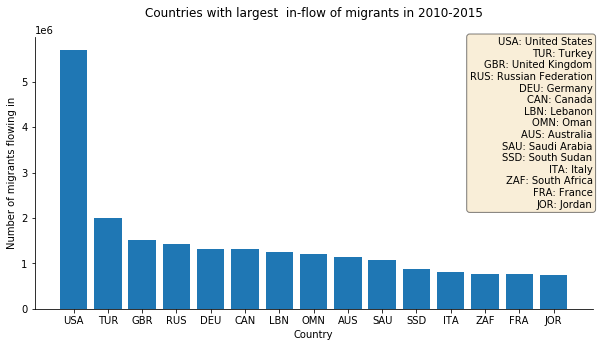

In [22]:
metric = 'sum'
direction = 'in'
colname = f'{metric}_{direction}'
df_max_inflowers = get_df_with_k_max_coutries(df_thin, colname, 2010, 'b', 15)
fig, ax = plot_country_bars(df_max_inflowers, metric, direction)

We can see that the USA is by large the country with the largest in-flow of people with a total flow almost 3 times larger than the one from the second country, Turkey.

Let's look at out-flows now.

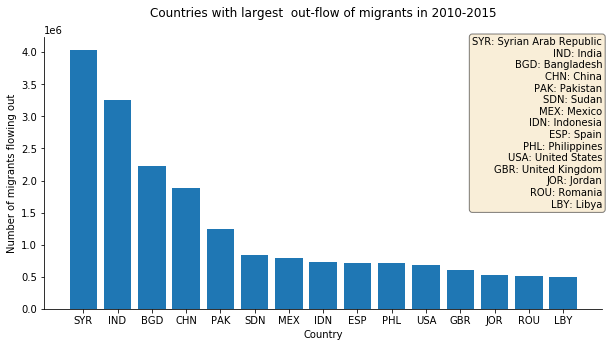

In [23]:
metric = 'sum'
direction = 'out'
colname = f'{metric}_{direction}'
df_max_outflowers = get_df_with_k_max_coutries(df_thin, colname, 2010, 'b', 15)
fig, ax = plot_country_bars(df_max_outflowers, metric, direction)

Here we observe that the largest outflow is from Syria, which undergoes a civil war since the March 2011 and is still ongoing at the time of writing (April 2020). 
We note that this war causing so many people to leave Syria to neighbouring countries may explain the presence of countries such as Turkey, Lebanon, Jordan in the top ranking of inflow countries above.

The four countries following Syria in this plot are all in the top 10 of the most populated countries.

#### Let's do the same but normalizing the flows with the local population of the country

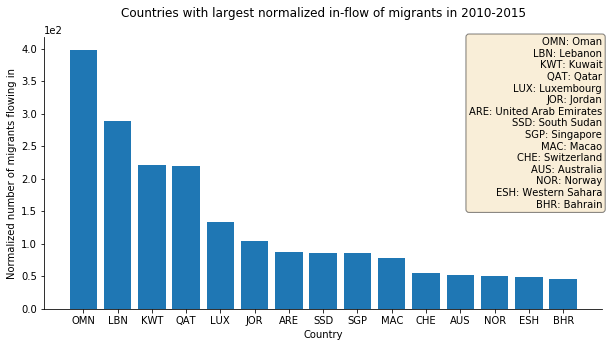

In [24]:
metric = 'sum'
direction = 'in'
colname = f'{metric}_{direction}'
df_max_inflowers_norm = get_df_with_k_max_coutries(df_thin, colname, 2010, 'b', 15, normalize=True)
fig, ax = plot_country_bars(df_max_inflowers_norm, metric, direction, normalize=True)

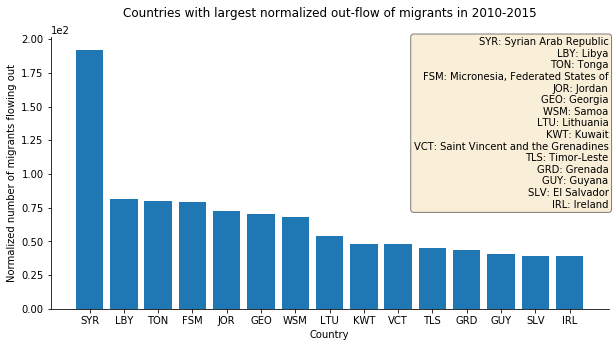

In [25]:
metric = 'sum'
direction = 'out'
colname = f'{metric}_{direction}'
df_max_outflowers_norm = get_df_with_k_max_coutries(df_thin, colname, 2010, 'b', 15, normalize=True)
fig, ax = plot_country_bars(df_max_outflowers_norm, metric, direction, normalize=True)

Syria's outflow of people is very large compared to its population size. 
Its outflow is more than twice larger than the one from the country ranked after it, Libya, which also underwent a civil war in 2011 and a second one from 2014 to present.

Interestingly, several Pacific islands' countries such as Tonga, Micronesia, and Samoa are among the 10 countries with the largest outflows per-capita.

### Let's now look at the difference in men and women flows

In [26]:
# compute difference female minus male (cumulative) migration flows
# outflow
df_out_thin_maleFemale = df_out_thin.pivot_table(values='sum_out', index=['year0', 'orig'], columns='sex')
df_out_thin_maleFemale['female_minus_male'] = df_out_thin_maleFemale.f - df_out_thin_maleFemale.m

# inflow
df_in_thin_maleFemale = df_in_thin.pivot_table(values='sum_in', index=['year0', 'dest'], columns='sex')
df_in_thin_maleFemale['female_minus_male'] = df_in_thin_maleFemale.f - df_in_thin_maleFemale.m

# prepare to join the two dfs: copy and change index name
df_in_thin_maleFemale_c = df_in_thin_maleFemale.copy()
df_in_thin_maleFemale_c.index.rename(['year0', 'orig'], inplace=True)
# join
df_thin_maleFemale = df_in_thin_maleFemale_c.join(df_out_thin_maleFemale, how='inner', lsuffix='_in', rsuffix='_out')

# add population information
df_thin_maleFemale = df_thin_maleFemale.join(df_pop, how='inner')
df_thin_maleFemale.head()

b_in           f_in           m_in  female_minus_male_in  \
year0 orig                                                                      
1995  LKA      398.083333     201.000000     247.916667            -46.916667   
2000  BLR    51781.777778   27032.666667   24341.000000           2691.666667   
2005  MDG     5107.555556    2488.555556    3132.071429           -643.515873   
      ALB     8732.333333    4610.666667    4051.857143            558.809524   
2000  HKG   250704.666667  165554.000000  100629.777778          64924.222222   

                    b_out          f_out          m_out  \
year0 orig                                                
1995  LKA   421457.500000  201907.541667  219726.166667   
2000  BLR    49306.000000   20731.333333   28174.666667   
2005  MDG     9794.777778    8871.000000    1867.071429   
      ALB   160373.111111   90088.666667   84776.857143   
2000  HKG   281898.638889  128931.416667  168453.305556   

            female_minus_male_out        pop  
year0 orig                                    
1995  LKA           -17818.625000  18247.121  
2000  BLR            -7443.333333   9933.609  
2005  MDG             7003.928571  18336.724  
      ALB             5311.809524   3079.179  
2000  HKG           -39521.888889   6663.654

In [27]:
def get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger=False, normalize=False):
    """Return a dataframe filtered for:
    the given year0 time interval, 
    the desired flow's direction (in or out),
    and ordered by: 
    the decreasing (female - male) difference if maleLarger is False, 
    and decreasing (male - female) dfference if maleLarger is True."""
    df_thin_maleFemale = df_thin_maleFemale.copy()
    colname = f'female_minus_male_{direction}'
    if normalize:
        df_thin_maleFemale[colname] = df_thin_maleFemale[colname] / df_thin_maleFemale['pop']
    cols2keep = [col for col in df_thin_maleFemale.columns if col.endswith(f'_{direction}')]
    cols2keep.append('pop')
    df_thin_maleFemale.drop(columns=[col for col in df_thin_maleFemale.columns if col not in cols2keep], inplace=True)
    
    return df_thin_maleFemale.sort_values(colname, ascending=maleLarger) \
        .sort_index(level='year0', sort_remaining=False) \
        .loc[(year0, slice(None)), :] \
        .head(k)

In [28]:
def plot_country_bars_maleFemale(df, direction, ax, maleLarger=False, normalize=False):
#     fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    colname = f'female_minus_male_{direction}'
    year0 = df.index.get_level_values('year0')[0]
    time_interval = f'{year0}-{year0 + 5}'
    country_codes = df.index.get_level_values('orig').values
    ax.bar(country_codes, np.abs(df[colname].values))
    if ~normalize:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_title(f'Countries with largest {"normalized" if normalize else ""} difference in {direction}-flow between women and men in {time_interval}', pad=20)
    ax.set_xlabel('Country')
    ax.set_ylabel(f'{"Normalized difference " if normalize else "Difference "}' 
                  f'{"(male - female)" if maleLarger else "(female - male)"} flowing {direction}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # add text box with country names:
    country_names_str = '\n'.join([f'{country_code}: {get_country_name(country_code)}' for country_code in country_codes])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(1, 1, country_names_str, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right', bbox=props)
    
    return ax

### Let's first look at the countries with more female than male migrating

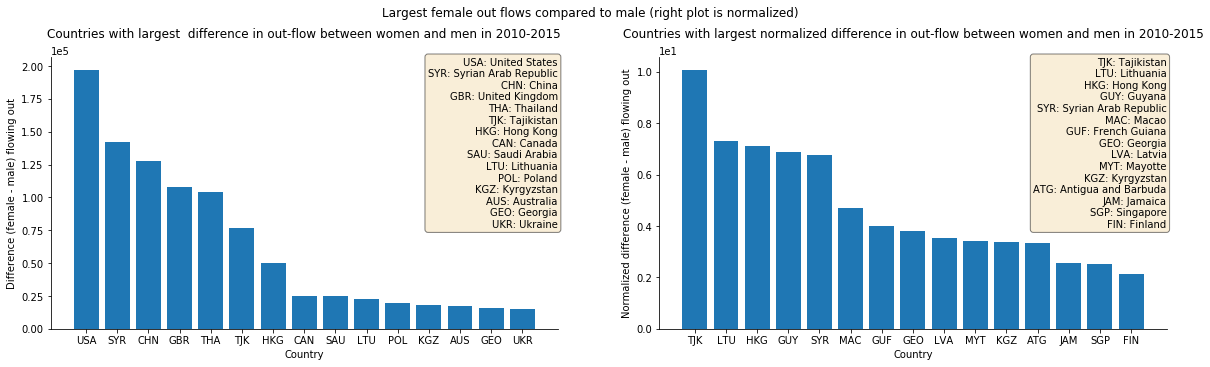

In [29]:
direction = 'out'
year0 = 2010
k = 15
maleLarger = False
df2plot = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=False)
df2plot_norm = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f'Largest {"male" if maleLarger else "female"} {direction} flows '
             f'compared to {"female" if maleLarger else "male"} (right plot is normalized)', y=1.02)
plot_country_bars_maleFemale(df2plot, direction, ax[0], maleLarger, normalize=False)
plot_country_bars_maleFemale(df2plot_norm, direction, ax[1], maleLarger, normalize=True)

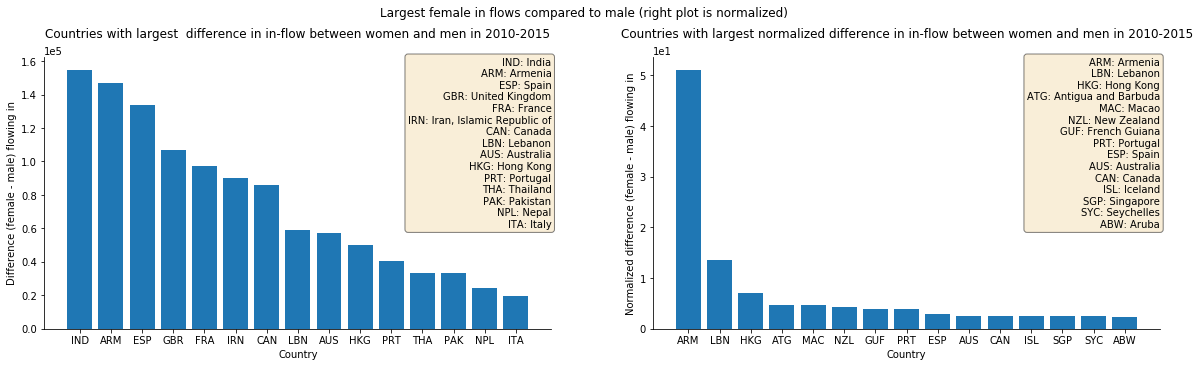

In [30]:
direction = 'in'
year0 = 2010
k = 15
maleLarger = False
df2plot = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=False)
df2plot_norm = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f'Largest {"male" if maleLarger else "female"} {direction} flows '
             f'compared to {"female" if maleLarger else "male"} (right plot is normalized)', y=1.02)
plot_country_bars_maleFemale(df2plot, direction, ax[0], maleLarger, normalize=False)
plot_country_bars_maleFemale(df2plot_norm, direction, ax[1], maleLarger, normalize=True)

### Let's now look at the countries with more male than female migrating

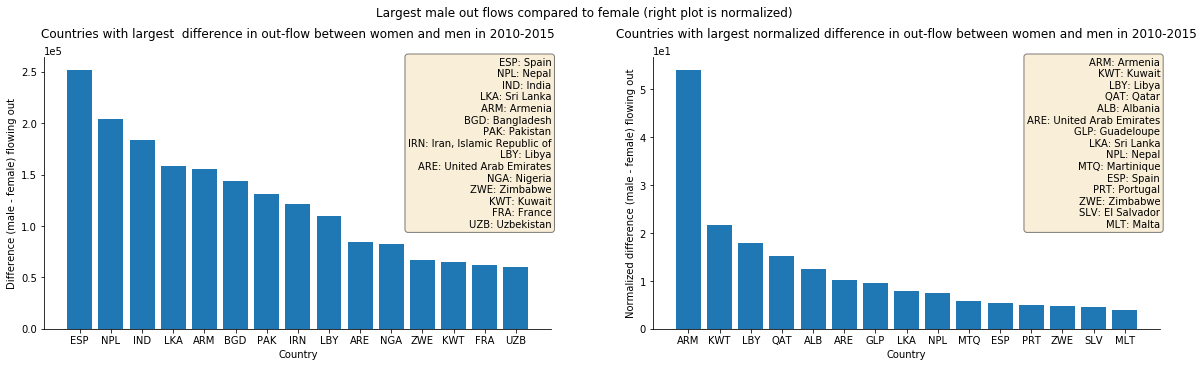

In [31]:
direction = 'out'
year0 = 2010
k = 15
maleLarger = True
df2plot = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=False)
df2plot_norm = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f'Largest {"male" if maleLarger else "female"} {direction} flows '
             f'compared to {"female" if maleLarger else "male"} (right plot is normalized)', y=1.02)
plot_country_bars_maleFemale(df2plot, direction, ax[0], maleLarger, normalize=False)
plot_country_bars_maleFemale(df2plot_norm, direction, ax[1], maleLarger, normalize=True)

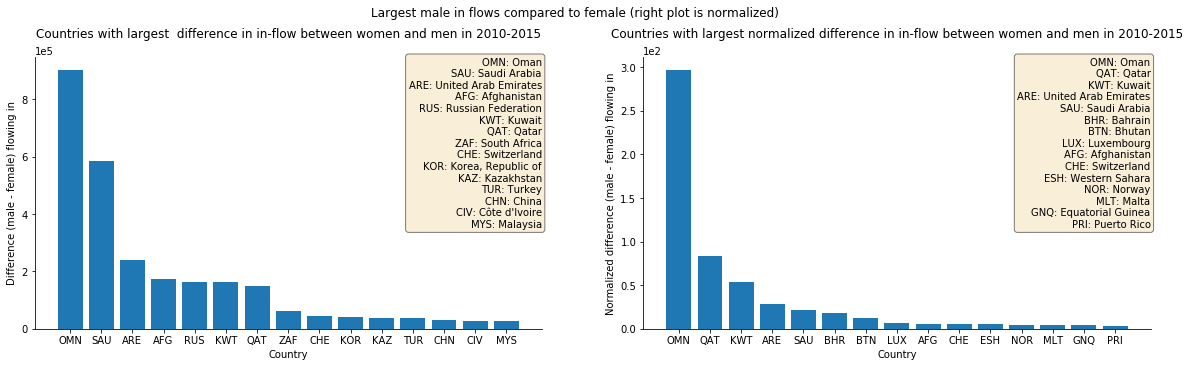

In [32]:
direction = 'in'
year0 = 2010
k = 15
maleLarger = True
df2plot = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=False)
df2plot_norm = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f'Largest {"male" if maleLarger else "female"} {direction} flows '
             f'compared to {"female" if maleLarger else "male"} (right plot is normalized)', y=1.02)
plot_country_bars_maleFemale(df2plot, direction, ax[0], maleLarger, normalize=False)
plot_country_bars_maleFemale(df2plot_norm, direction, ax[1], maleLarger, normalize=True)